In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

check_gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE" )

#tipos de datos 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)   #establece el tipo de float predeterminado

GPU is available



# Ecuación de Burger
Sea $\Omega = [0,1]\times [-1,1]$. Determinar $u(t,x)$ que satisfaga: 

1. $$u_t + uu_x - (0.01/\pi)u_{xx} = 0 \hspace{0.8cm}  \text{En el interior de } \Omega$$

2. $$u(0,x) = -\sin(\pi x ) $$

3. $$u(t,-1) = u(t,1) = 0 $$


## Enfoque PINNs 
Considere los siguientes conjuntos de puntos:

$\{t_j^{e},x_j^{e}\}_{j=1}^{N_e}$ un conjunto de puntos en el interior de $\Omega$.

$\{t_j^{1},x_j^{1}\}_{j=1}^{N_1}$ un conjunto de puntos en $[0,1]\times\{1\}$. 

$\{t_j^{2},x_j^{2}\}_{j=1}^{N_2}$ un conjunto de puntos en $[0,1]\times\{-1\}$.

$\{t_j^{i},x_j^{i}\}_{j=1}^{N_i}$ un conjunto de puntos en $\{0\}\times [0,1]$.



Sea $\hat{u}(x,t; \vec{\theta})$ una red neuronal feed-forward con dos neuronas de entradas, una neurana de salida, con $l$ capas ocultas de $l_n$ neuronas para cada capa oculta. El enfoque PINNs sostiene que la solución del problema 1-2-3 se reduce a determinar los pesos y sesgos (vector $\vec{\theta}$) de la red $\hat{u}$ que minimiza la siguiente función de pérdida:

$$\mathcal{L}(\vec{\theta}) =  \mathcal{L}_r(\vec{\theta}) + \mathcal{L}_{r_1}(\vec{\theta}) + \mathcal{L}_{r_2}(\vec{\theta}) + \mathcal{L}_{r_i}(\vec{\theta})$$


donde 

$$\mathcal{L}_r(\vec{\theta}) = \dfrac{1}{N_i}\sum_{n = 1}^{N_i} \left(\hat{u}_t(t_n^{e},x_n^{e})  + \hat{u}(t_n^{e},x_n^{e}) \hat{u}_x(t_n^{e},x_n^{e})  - (0.001 / \pi)\hat{u}_{xx}(t_n^{e},x_n^{e}) \right)^2,$$

$$\mathcal{L}_{r_1}(\vec{\theta}) = \dfrac{1}{N_1}\sum_{n = 1}^{N_1}  \left(\hat{u}(t_n^{1},x_n^{1}) - 0  \right)^2,$$

$$\mathcal{L}_{r_2}(\vec{\theta}) = \dfrac{1}{N_2}\sum_{n = 1}^{N_2}  \left(\hat{u}(t_n^{2},x_n^{2}) - 0  \right)^2,$$

$$\mathcal{L}_{inicial}(\vec{\theta}) = \dfrac{1}{N_i}\sum_{n = 1}^{N_i}  \left(\hat{u}(t_n^{i},x_n^{i}) - [-\sin(\pi x_n^{i})] \right)^2.$$





## Dominios

In [2]:
#límites del dominio del problema
tmin = 0.0
tmax = 1.0
xmin = -1.0
xmax = 1.0

In [88]:
#puntos donde la función de perdida satisface la ecuacion diferencia 1.
N_r = 1200
t_r = tf.constant(tmin + (tmax - tmin)*np.random.random(N_r), shape = (N_r,1), dtype = DTYPE)
x_r = tf.constant(xmin + (xmax - xmin)*np.random.random(N_r), shape = (N_r,1), dtype = DTYPE)
X_r = tf.concat([t_r, x_r], axis = 1)
#plt.scatter(t_r, x_r, marker = 'x', color = 'b')
#plt.xlabel('t')
#plt.ylabel('x')

In [89]:
N_u = 100 

#puntos del dominio donde se satisface la condición 2.
t_i = tf.zeros((N_u,1), dtype = DTYPE)
x_i = tf.constant(xmin + (xmax - xmin)*np.random.random(N_u), shape = (N_u,1), dtype = DTYPE)
X_i = tf.concat([t_i, x_i], axis = 1)

#puntos del dominio donde se satisface la condición 3.
t_1 = tf.constant(tmin + (tmax - tmin)*np.random.random(N_u), shape = (N_u,1), dtype = DTYPE)
x_1 = tf.ones((N_u,1), dtype = DTYPE) * 1.0
X_1 = tf.concat([t_1, x_1], axis = 1)

t_2 = tf.constant(tmin + (tmax - tmin)*np.random.random(N_u), shape = (N_u,1), dtype = DTYPE)
x_2 = tf.ones((N_u,1), dtype = DTYPE) * -1.0
X_2 = tf.concat([t_2, x_2], axis = 1)


Text(0, 0.5, 'x')

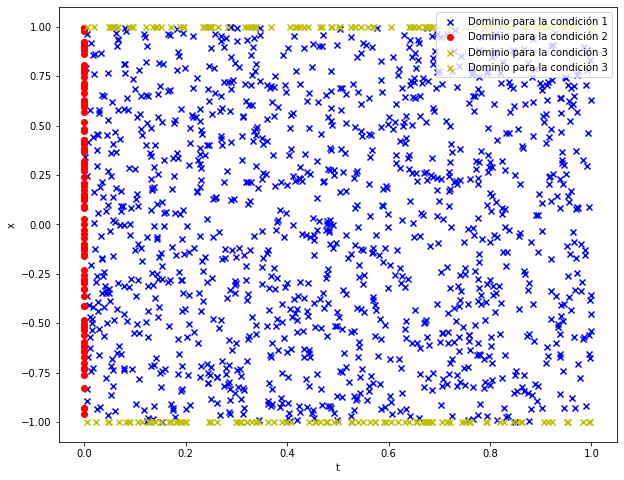

In [90]:
plt.figure(figsize=(10,8))
plt.scatter(t_r, x_r, marker = 'x', color = 'b', label = 'Dominio para la condición 1')
plt.scatter(t_i, x_i, marker = 'o', color = 'r', label = 'Dominio para la condición 2')
plt.scatter(t_1,x_1, marker = 'x', color = 'y', label = 'Dominio para la condición 3' )
plt.scatter(t_2,x_2, marker = 'x', color = 'y', label = 'Dominio para la condición 3' )
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('x')

## Funciones para definir la condicion inicial, condición de borde y la EDP 

In [91]:
#condicion inicial
def f(X):
    t = X[:,0:1]
    x = X[:,1:2]
    return -1 * tf.sin(np.pi*x)

In [92]:
#condicion de borde 
def g(X):
    t = X[:,0:1]
    x = X[:,1:2]
    return tf.zeros_like(t)

In [93]:
#Edp
def f_res(u, u_x, u_t, u_xx):
    return u_t + u * u_x - (0.01)/np.pi * u_xx

## Modelo Pinns

In [94]:
#Red Neuronal
def init_model(num_hidden_layers = 3, num_neurons_per_layer = 20 ):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(2))

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, 
                                        activation = tf.keras.activations.get('tanh'),
                                       kernel_initializer = 'glorot_normal'))
    
    model.add(tf.keras.layers.Dense(1))
    return model

In [95]:
#Derivadas de la red neuronal
def get_deriv(model, X):
    t = X[:,0:1]
    x = X[:,1:2]
    with tf.GradientTape(persistent=True) as outer_tape:
        outer_tape.watch(t)
        outer_tape.watch(x)
        with tf.GradientTape(persistent=True) as inner_tape:
            inner_tape.watch(t)
            inner_tape.watch(x)
            u = model(tf.concat([t, x], axis = 1))
        u_t = inner_tape.gradient(u, t)
        u_x = inner_tape.gradient(u, x)
    u_xx = outer_tape.gradient(u_x, x)
    return  u, u_x, u_t, u_xx                       

In [96]:
#Calculo de la función de pérdida
def compute_loss(model, X_colocacion, X_inicial, X_borde_1, X_borde_2):
    u, u_x, u_t, u_xx = get_deriv(model, X_colocacion)
    
    r = tf.reduce_mean(tf.square(f_res(u, u_x, u_t, u_xx)))
    r_inicial = tf.reduce_mean(tf.square(model(X_inicial) - f(X_inicial)))
    r_borde_1 = tf.reduce_mean(tf.square(model(X_borde_1) - g(X_borde_1)))
    r_borde_2 = tf.reduce_mean(tf.square(model(X_borde_2) - g(X_borde_2)))
  
    loss = r + r_inicial + r_borde_1 + r_borde_2
    return loss, r, r_inicial, r_borde_1, r_borde_2

In [97]:
#Derivada de la función de pérdida con respecto a los pesos de la red neuronal
def get_grad_loss(model, X_colocacion, X_inicial, X_borde_1, X_borde_2):
    with tf.GradientTape() as tape:
        loss, _, _, _, _ = compute_loss(model, X_colocacion, X_inicial, X_borde_1, X_borde_2)
    g = tape.gradient(loss, model.trainable_variables)
    return loss, g

In [4]:
optim = tf.keras.optimizers.Adam(0.001)

In [98]:
#Función que realiza un paso en el preceso de descenso de gradiente aplicado a la función de pérdida
@tf.function 
def train_step(model, X_colocacion, X_inicial, X_borde_1, X_borde_2):
    loss, grad_theta = get_grad_loss(model, X_colocacion, X_inicial, X_borde_1, X_borde_2)
    
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))  #un paso descenso de gradiente
    return loss

In [99]:
#instanciar el modelo
model_1 = init_model()

In [100]:
#diccionario que guardará el conmputo de las componentes de la loss
hist = {'loss': [],
        'r_pinn': [],
        'r_i': [],
        'r_1': [],
        'r_2': [], 
        } 

In [104]:
from time import time  

#Número de Épocas
N = 10000

#Comienzo del tiempo
t0 = time()

#Entrenamiento
for i in range(N+1):
    #Optimizador para el proceso de minimización de la función de pérdida
    
    #hacer 10000 iteraciones con tasa 0.001 y luego 10000 iteraciones con tasa 0.0001
    #optim = tf.keras.optimizers.Adam(0.001)    #para primeras iteraciones
    optim = tf.keras.optimizers.Adam(0.0001)    #para siguientes iteraciones

    #Actualización de los pesos de la función de pérdida 
    loss = train_step(model_1, X_r, X_i, X_1, X_2)  

    #guarda valores de cada componte de la función de pérdida en cada iteración
    _, r_pinn, r_i, r_1, r_2 = compute_loss(model_1, X_r, X_i, X_1, X_2)  

    hist['loss'].append(loss.numpy())
    hist['r_pinn'].append(r_pinn.numpy())
    hist['r_i'].append(r_i.numpy())
    hist['r_1'].append(r_1.numpy())
    hist['r_2'].append(r_2.numpy())

    #Visualiza el avance de la función de pérdida
    if i%1000 == 0:
        print(f'It {i:05d}: loss = {loss:10.8e}')
        
#Mostrar tiempo de calculo 
print(f'Tiempo de Cómputo: {time()-t0} segundos')


It 00000: loss = 1.96496886e-03
It 01000: loss = 1.37872412e-03
It 02000: loss = 1.18258817e-03
It 03000: loss = 1.04498514e-03
It 04000: loss = 9.58568649e-04
It 05000: loss = 1.00465480e-03
It 06000: loss = 1.26521231e-03
It 07000: loss = 7.17289629e-04
It 08000: loss = 6.64733350e-04
It 09000: loss = 6.65738073e-04
It 10000: loss = 5.92406956e-04
Tiempo de Cómputo: 222.39650797843933 segundos


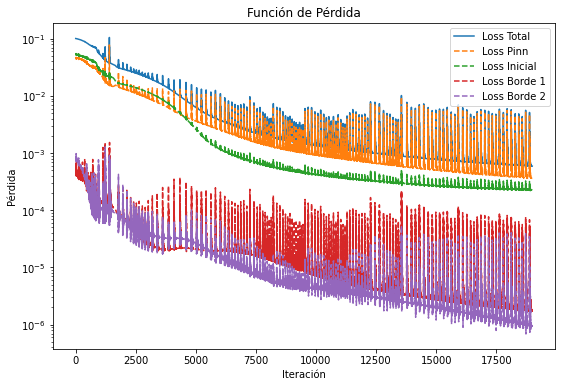

In [105]:
#gráfica pérdida
plt.figure(figsize=(9,6))

plt.plot(range(len(hist['loss'][1000:])), hist['loss'][1000:], label = 'Loss Total')
plt.plot(range(len(hist['r_pinn'][1000:])), hist['r_pinn'][1000:], label = 'Loss Pinn', linestyle = '--')
plt.plot(range(len(hist['r_i'][1000:])), hist['r_i'][1000:], label = 'Loss Inicial', linestyle = '--')
plt.plot(range(len(hist['r_1'][1000:])), hist['r_1'][1000:], label = 'Loss Borde 1', linestyle = '--')
plt.plot(range(len(hist['r_2'][1000:])), hist['r_2'][1000:], label = 'Loss Borde 2', linestyle = '--')
plt.title('Función de Pérdida')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.show()

In [106]:
from ipywidgets import interactive
import ipywidgets as widgets

#grafica solución 
N = 500

tspace = np.linspace(tmin, tmax, N + 1)
xspace = np.linspace(xmin, xmax, N + 1)
tspace = np.linspace(tmin, tmax, N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model_1(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

def plot_surface(elev=30, azim=30):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, U, cmap='viridis')
    ax.view_init(elev, azim)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_zlabel('$u_\\theta(t,x)$')
    ax.set_title('Solution Pinn Burger')
    plt.show()

elev_slider = widgets.IntSlider(min=0, max=90, step=1, value=30, description='Elevación')
azim_slider = widgets.IntSlider(min=0, max=360, step=1, value=30, description='Azimut')

interactive_plot = interactive(plot_surface, elev=elev_slider, azim=azim_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


interactive(children=(IntSlider(value=30, description='Elevación', max=90), IntSlider(value=30, description='A…